# Convolutional Neural Network

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Modules](#Python-Modules)
  * [Data](#Data)
* [Teaching Content](#Teaching-Content)
  * [Accessing our Preprocessed Data](#Accessing-our-Preprocessed-Data)
* [Exercises](#Exercises)
  * [Normalization](#Normalization)
  * [Defining the Convolution Neural Network](#Defining-the-Convolution-Neural-Network)
  * [Training](#Training)
  * [Saving the Trained Model](#Saving-the-Trained-Model)
  * [Plots](#Plots)
* [Summary and Outlook](#Summary-and-Outlook)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction

In this notebook you will define a Convolutional Neural Network (CNN), using the `tensorflow.keras` API, to predict, whether a tile contains tumorous tissue or not. Since the data handling process with a `generator` can be tricky you will be supplied with a class, which handles access to our HDF5 file.

## Requirements
### Python-Modules

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
import math
from datetime import datetime

# Furcifar Modules
from preprocessing.util import find_files
from preprocessing.datamodel import SlideManager
from preprocessing.util import TileMap

%matplotlib inline

2023-06-23 09:03:50.777427: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-23 09:03:50.832701: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-23 09:03:50.833269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 09:03:51.766679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data

In this notebook we use perviously preprocessed data of the CAMELYON16 data set.

To set the data set location please adjust the path bellow to the directory of preprocessed hdf5 files.

**Hint:**

If you have the possibility, copy the generated HDF5 file onto SSD

In [2]:
# EDIT THIS CELL (Option B of last notebook)
# Path where your HDF5 file is located
GENERATED_DATA = "/storage/jitbitan/outputs/cam16_tiles/"
HDF5_FILE = GENERATED_DATA + "all_wsi_tile256_poiNormal0.2_poiTumor0.6_level3.hdf5"

In [3]:
# EDIT THIS CELL (Option A of last notebook)
# Path where your HDF5 file is located
#GENERATED_DATA = '/home/klaus/Documents/datasets/PN-STAGE/level0/'
#HDF5_FILE = GENERATED_DATA + 'all_wsis_312x312_poi0.2_poiTumor0.6_level0.hdf5'

In [4]:
# This is where we save checkpoints for our model
MODEL_CHECKPOINT = GENERATED_DATA + 'model_checkpoint.ckpt'
MODEL_FINAL = GENERATED_DATA + 'model_final.hdf5'

First, let us see if we can access our HDF5 file

In [5]:
data_file = h5py.File(HDF5_FILE,'r',libver='latest',swmr=True)
print('List of data entires')
for key in data_file.keys():
    print(key, 'with shape', data_file[key].shape)

List of data entires
normal_001 with shape (185, 256, 256, 3)
normal_002 with shape (324, 256, 256, 3)
normal_003 with shape (398, 256, 256, 3)
normal_004 with shape (111, 256, 256, 3)
normal_005 with shape (256, 256, 256, 3)
normal_006 with shape (86, 256, 256, 3)
normal_007 with shape (320, 256, 256, 3)
normal_008 with shape (164, 256, 256, 3)
normal_009 with shape (469, 256, 256, 3)
normal_010 with shape (201, 256, 256, 3)
normal_011 with shape (888, 256, 256, 3)
normal_012 with shape (232, 256, 256, 3)
normal_013 with shape (145, 256, 256, 3)
normal_014 with shape (221, 256, 256, 3)
normal_015 with shape (421, 256, 256, 3)
normal_016 with shape (77, 256, 256, 3)
normal_017 with shape (42, 256, 256, 3)
normal_018 with shape (234, 256, 256, 3)
normal_019 with shape (23, 256, 256, 3)
normal_020 with shape (68, 256, 256, 3)
normal_021 with shape (37, 256, 256, 3)
normal_022 with shape (501, 256, 256, 3)
normal_023 with shape (127, 256, 256, 3)
normal_024 with shape (996, 256, 256, 3)
n

## Teaching Content
### Accessing our Preprocessed Data

First we define a class which handles access to our generated HDF5 file. The requirements for this class are:
- Return a batch of examples as 4D-numpy array (n_examples, tile-width, tile-height, color-channels) together with the labels for each example
- Return specified number of examples of each class per batch
- Randomly chose the examples of each class
- Clearly split training and validation data

In [6]:
class TissueDataset():
    """Data set for preprocessed WSIs of the CAMELYON16 and CAMELYON17 data set."""
        
    def __init__(self, path, percentage=.5, first_part=True):      
        self.h5_file = path
        self.h5 = h5py.File(path, 'r', libver='latest', swmr=True)
        self.perc = percentage
        self.first_part = first_part
        self.dataset_names = list(self.h5.keys())
        self.neg = [i for i in self.dataset_names if 'ormal' in i]
        self.pos = [i for i in self.dataset_names if 'umor' in i]
        self.dims = self.h5[self.neg[0]][0].shape
    
    def __get_tiles_from_path(self, dataset_names, max_wsis, number_tiles):
        tiles = np.ndarray((number_tiles, 256, 256, 3))
        for i in range(number_tiles):
            file_idx = np.random.randint(0, max_wsis)
            dset = self.h5[dataset_names[file_idx]]
            len_ds = len(dset)
            max_tiles = math.ceil(len_ds * self.perc)
            if self.first_part:
                rnd_idx = np.random.randint(0, max_tiles)
            else:
                rnd_idx = np.random.randint(len_ds - max_tiles, len_ds)
            ### crop random 256x256
            if self.dims[1] > 256:
                rand_height = np.random.randint(0, self.dims[0]-256)
                rand_width = np.random.randint(0, self.dims[1]-256)
            else:
                rand_height = 0
                rand_width = 0
            tiles[i] = dset[rnd_idx,rand_height:rand_height+256,rand_width:rand_width+256]
        tiles = tiles / 255.
        return tiles
    
    def __get_random_positive_tiles(self, number_tiles):
        return self.__get_tiles_from_path(self.pos, len(self.pos), number_tiles), np.ones((number_tiles))
    
    def __get_random_negative_tiles(self, number_tiles):
        return self.__get_tiles_from_path(self.neg, len(self.neg), number_tiles), np.zeros((number_tiles))
    
    def generator(self, num_neg=10, num_pos=10, data_augm=False, mean=[0.,0.,0.], std=[1.,1.,1.]):
        while True:
            x, y = self.get_batch(num_neg, num_pos, data_augm)
            for i in [0,1,2]:
                x[:,:,:,i] = (x[:,:,:,i] - mean[i]) / std[i]
            yield x, y

    def get_batch(self, num_neg=10, num_pos=10, data_augm=False):
        x_p, y_p = self.__get_random_positive_tiles(num_pos)
        x_n, y_n = self.__get_random_negative_tiles(num_neg)
        x = np.concatenate((x_p, x_n), axis=0)
        y = np.concatenate((y_p, y_n), axis=0)
        if data_augm:
            ### some data augmentation mirroring / rotation
            if np.random.randint(0,2): x = np.flip(x, axis=1)
            if np.random.randint(0,2): x = np.flip(x, axis=2)
            x = np.rot90(m=x, k=np.random.randint(0,4), axes=(1,2))
        ### randomly arrange in order
        p = np.random.permutation(len(y))
        return x[p], y[p]

We can now load our data set split into training and validation data.
By setting `train_data = TissueDataset(path=HDF5_FILE,  percentage=0.5, first_part=True)`, we say that `training_data` consists of the first 50% of tiles of every WSI.

The method `get_batch` returns a specified number of positive and negative slides. The slides are randomly shuffeled, so the first part of the batch does not only contain positive slides, and the last part of the batch only negtive slides.

In [7]:
train_data = TissueDataset(path=HDF5_FILE,  percentage=0.5, first_part=True)
val_data = TissueDataset(path=HDF5_FILE, percentage=0.5, first_part=False)

x, y = train_data.get_batch(num_neg=3, num_pos=3)
print(x.shape)
print(y)

(6, 256, 256, 3)
[0. 0. 1. 1. 0. 1.]


The `generator` method does the same as `get_batch`, but implements a python generator, which is very useful when training and evaluating a `tensorflow.keras` model.

The method argument `data_augm=True` randomly rotates the batch zero to three times by 90 degrees and randomly flips is horizonally and / or vertically.

By plotting the examples of a batch we can see, that the slides have been successfully stored in the HDF5 file and we are also able to successfully load them together with the labels:

(2, 256, 256, 3)


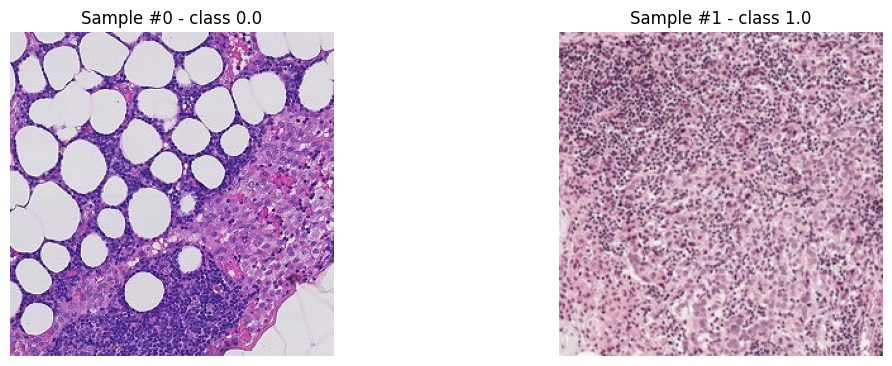

In [8]:
plt.figure(figsize=(12,4))

itera = train_data.generator(num_neg=1, num_pos=1, data_augm=True)
for x, y in itera:
    print(x.shape)
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{} - class {}'.format(i, y[i]))
        ax.imshow(x[i])
        ax.axis('off') 
    break # generate yields infinite random samples, so we stop after first

## Exercises

### Normalization

There are far superior normalization methods for WSI-tasks. If you are interested you can read more about such methods in [MAG09] and [ROY18])

For now, we will stick with a standard way of normalization by subtracting the mean and dividing by the standard deviation.

So next we will fetch a big batch and calculate the mean and standard deviation **colorwise**.

**Task:**

Query a big batch from the whole dataset (not just the test set). Make it as big as your RAM can handle, though 200 negative and 200 positive slides should be sufficient. Then calculate the mean and standard deviation for each color channel and save them into `mean_pixel` and `std_pixel`

In [12]:
mean_pixel = np.full((3),0.0)
std_pixel = np.full((3),1.0)

# mean_channel = []
# std_channel = []

# with h5py.File(HDF5_FILE, "r") as f:
#     all_keys = f.keys()
#     for key in all_keys:
#         data = f[key][:]
#         mean_channel.append(np.mean(data, axis=(0, 1, 2)))
#         std_channel.append(np.std(data, axis=(0, 1, 2)))

# mean_channel_pixel = np.stack(mean_channel)
# std_channel_pixel = np.stack(std_channel)

# mean_pixel = np.mean(mean_channel_pixel, axis=0)
# std_pixel = np.std(std_channel_pixel, axis=0)

KeyboardInterrupt: 

In [10]:
### Exercise: Query a big batch and save the mean and standard deviation 
### for each channel into the variable devined above

We can also visualize the mean image and the image for the standard deviation. Although we do not need a full sized tile of them. The 1D-array is enough for normalization and also probably faster computation wise.

But still visualizing them as full sized tiles gives some insight about the mean of the colors and their veriance.

If everything is correct, executing the following cell will show the following image:

![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/master/media/klaus/medical-image-classification/mean_and_std_dev_images.png)

Mean colors:  [0. 0. 0.]
Std Dev colors:  [1. 1. 1.]


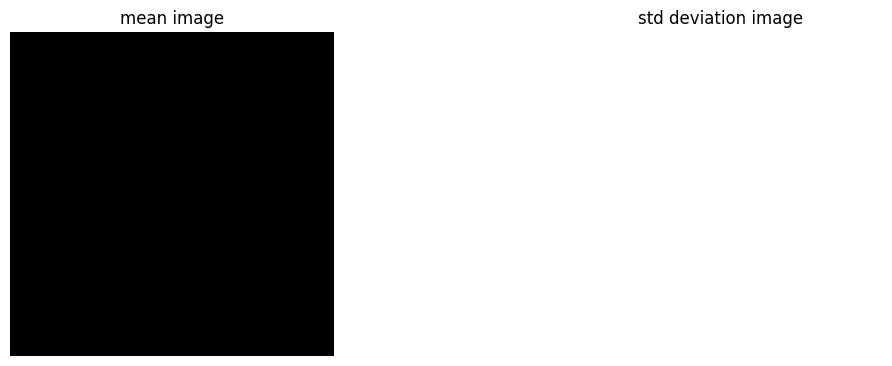

In [11]:
mean_img = np.full((256,256,3),0.0)
std_img = np.full((256,256,3),0.0)
mean_img[:,:] = mean_pixel
std_img[:,:] = std_pixel

plt.figure(figsize=(12,4))

# Mean image
ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.set_title('mean image')
ax.imshow(mean_img)
ax.axis('off')
# Std Deviation image
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('std deviation image')
ax.imshow(std_img)
ax.axis('off') 

print('Mean colors: ', mean_pixel)
print('Std Dev colors: ', std_pixel)

By passing `mean_pixel` and `standard pixel` into the `generator` method we get normalized images. The images will look like something is wrong with them, but this is just because we now have pixel values centered around 0.0 (probably most likely from -3 to +3). `matplotlib` either wants integer from 0 to 255 or floats form 0.0 to 1.0. The CNN however will converge a lot faster and probably also a lot better in the end.

Executing the cell below should yield an image similar to the following:

![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/master/media/klaus/medical-image-classification/normalized_images.png)

In [ ]:
plt.figure(figsize=(12,4))

itera = train_data.generator(1, 1, True, mean_pixel, std_pixel)
for x, y in itera:
    print(x.shape)
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{} - class {}'.format(i, y[i]))
        ax.imshow(x[i])
        ax.axis('off') 
    break # generate yields infinite random samples, so we stop after first

### Defining the Convolution Neural Network

**Task:**

Define a model for the training. Use classes / methods from `tensorflow.keras`. Also compile your model with an optimizer, a loss and a metric (e.g. _accuracy_). As we only have two classes, we can use the _binary crossentropy_ as loss function.

#### Suggested Models

If you do not feel like experimenting (takes a lot of time), we can suggest to try out the following model:
    * InceptionResNetV2 with pretrained weights on ImageNet.
    * We ditch pretrained last layers.
    * Benefit is that CNNs tend to develop the same filters for the first convolution layers

In [ ]:
base_model = keras.applications.InceptionResNetV2(
                                 include_top=False, 
                                 weights='imagenet', 
                                 input_shape=(256,256,3), 
                                 )

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# If you interrupted your training, load the checkpoint here:

model.load_weights(MODEL_CHECKPOINT)

### Training

**Task:**

- Train and Evaluate your model.
- Keep track of the metrics _loss_ and _accuracy_ for training and validation data, since we want to plot these later.

**Hints:**

- Make checkpoints every epoch.
- Use the `fit_generator` method of your model and pass our `generator` method as parameter
- The following parameters showed to work well using a **Geforce 1080 TI (11 GB RAM)**:
    - Each epoch consists of 100 training batches and 50 validations batches
    - Each batch contains 20 negatives and 20 positives
    - Train for at least 50 epochs (15 hours on Geforce 1080 TI, slide-magnification level 3 (Option A) used)
- If you want to try these settings but get an out of memory (OOM) error, adjust the batch size.


**Hint:**

If you have the possibility, copy the generated HDF5 file onto SSD

In [ ]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

batch_size_neg=20
batch_size_pos=20
batches_per_train_epoch = 100
batches_per_val_epoch = 50
epochs = 50

In [ ]:
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(MODEL_CHECKPOINT, 
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
now1 = datetime.now()

### Uncomment to easily disable color normalization
#mean_pixel = [0.,0.,0.] 
#std_pixel = [1.,1.,1.]  

for i in range(epochs):
    hist = model.fit_generator(
            generator=train_data.generator(batch_size_neg, batch_size_pos, True, mean_pixel, std_pixel),
            steps_per_epoch=batches_per_train_epoch, 
            validation_data=val_data.generator(batch_size_neg, batch_size_pos, False, mean_pixel, std_pixel),
            validation_steps=batches_per_val_epoch,
            callbacks=[cp_callback], workers=1, use_multiprocessing=False, max_queue_size=10)
    
    train_accs.append(hist.history['acc'])
    train_losses.append(hist.history['loss'])
    val_accs.append(hist.history['val_acc'])
    val_losses.append(hist.history['val_loss'])

now2 = datetime.now()
print(now2 - now1)

### Saving the Trained Model

Since checkpoints only save weights, now save the whole model, so we won't need the code to generate the model in the next notebooks.

In [ ]:
# Save entire model to a HDF5 file
model.save(MODEL_FINAL)

### Plots

**Task:**

Plot the progress of your training over the epochs. That means the _loss_ and the _accuracy_ for the validation as well as the training data

Your plots should look similar to these if training was successful:

<img src="https://gitlab.com/deep.TEACHING/educational-materials/raw/master/media/klaus/medical-image-classification/cnn_resultsplot_vgg_no_dense_120_epoch.png" width="768" alt="internet connection needed">

**Note:**

The reason that the curves are not smooth is because we do no always feed the whole dataset, neither for training, nor for validation. So it happens, that some batches contain tiles, which are easier to predict, or extremely hard to predict. So therefore the spikes.

The image above was created with a CNN with no pretrained weights. So if you have used the code provided with pretrained weights on ImageNet, ~90% accuracy will already be reached after the first couple of epochs.

In [ ]:
### Exercise: Plot the training progress

## Summary and Outlook

After this notebook you have a trained CNN, which is able to predict whether a slide contain tumorous tissue or not.

In the next notebook you will use this model to predict the tiles of the slides of the CAMELYON16 test set and to produce heatmaps of the slides.

Possibilities to improve your CNN:
- Advanced color normalization for histopathologic images (see [MAG09], [ROY18])
- More data augmentation (e.g. by adding some random noise)
- More state of the art CNN arhcitectures, e.g. inception v4 (see [SZE17])
- Use a higher zoom level (very time consuming)
- Try to implement Scannet (see [LIN18]) 
    * Hundreds of faster prediction time
    * For Prediction phase later it uses bigger tiles as input, e.g. 2868x2868 and outputs scores on a map with 86x86 pixels

## Literature



<table>
    <tr>
        <td>
            <a name="LIN18"></a>[LIN18]
        </td>
        <td>
Lin, H., Chen, H., Dou, Q., Wang, L., Qin, J., Heng, P.: Scannet: A fast and densescanning framework for metastastic breast cancer detection from whole-slide image. In: 2018 IEEE Winter Conference on Applications of Computer Vision (WACV).pp. 539–546 (March 2018). https://doi.org/10.1109/WACV.2018.00065
        </td>
    </tr>
        <tr>
        <td>
            <a name="MAG09"></a>[MAG09]
        </td>
        <td>
Magee, D., Treanor, D., Crellin, D., Shires, M., Smith, K., Mohee, K., Quirke, P.:Colour normalisation in digital histopathology images. Proc Optical Tissue Imageanalysis in Microscopy, Histopathology and Endoscopy (MICCAI Workshop) (01 2009)
        </td>
    </tr>
    <tr>
        <td>
            <a name="ROY18"></a>[ROY18]
        </td>
        <td>
Roy,   S.,   kumar   Jain,   A.,   Lal,   S.,   Kini,   J.:   A   study   about   color   nor-malizationmethodsforhistopathologyimages.Micron114,42–61(2018).https://doi.org/https://doi.org/10.1016/j.micron.2018.07.005,http://www.sciencedirect.com/science/article/pii/S0968432818300982
        </td>
    </tr>
    <!--
    <tr>
        <td>
            <a name="KRI12"></a>[KRI12]
        </td>
        <td>
            Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. In Advances in neural information processing systems (pp. 1097-1105).
        </td>
    </tr>
    -->
    <tr>
        <td>
            <a name="SZE17"></a>[SZE17]
        </td>
        <td>
            Szegedy, Christian, et al. "Inception-v4, inception-resnet and the impact of residual connections on learning." AAAI. Vol. 4. 2017.
        </td>
    </tr>
    <tr>
        <td>
            <a name="ZEI14"></a>[ZEI14]
        </td>
        <td>
            Zeiler, M. D., & Fergus, R. (2014, September). Visualizing and understanding convolutional networks. In European conference on computer vision (pp. 818-833). Springer, Cham.
        </td>
    </tr>
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

exercise-train-cnn-tensorflow<br/>
by Klaus Strohmenger<br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Klaus Strohmenger

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.